In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from scipy.optimize import minimize
import scipy.stats as stats

sns.set_theme(style="whitegrid", context="notebook")

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META']
prices = yf.download(
    tickers, 
    start='2015-01-01', 
    end='2025-01-01',
    interval='1d',
    auto_adjust=True,
    progress=False
)['Close']
display(prices)

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2015-01-02,24.237549,15.426000,26.296135,77.969345,39.933044,0.483038,14.620667
2015-01-05,23.554743,15.109500,25.795090,76.717056,39.565845,0.474880,14.006000
2015-01-06,23.556959,14.764500,25.158480,75.683441,38.985123,0.460482,14.085333
2015-01-07,23.887281,14.921000,25.084492,75.683441,39.480438,0.459282,14.063333
2015-01-08,24.805082,15.023000,25.171888,77.700996,40.641876,0.476559,14.041333
...,...,...,...,...,...,...,...
2024-12-24,257.037506,229.050003,195.472733,606.333679,436.929108,140.189468,462.279999
2024-12-26,257.853760,227.050003,194.964386,601.943970,435.715790,139.899521,454.130005
2024-12-27,254.439224,223.750000,192.133591,598.412231,428.177185,136.980164,431.660004


In [3]:
if prices.isna().sum().sum() > 0:
    print("Found missing values in price data.")
    print(prices.isna().sum())
    prices = prices.ffill().bfill()
    print("Missing values have been filled using forward-fill first, then backward-fill.")

In [4]:
returns = (1 + prices.pct_change()).fillna(1) # e.g. 1, 1.05, 1.02 for +5% then +2%
log_returns = np.log(returns) # e.g. log(1)=0, log(1.05)≈0.05, log(1.02)≈0.02 (NOTE: log(1 + x) ≈ x for small x)
assert np.allclose(np.exp(log_returns.cumsum()), returns.cumprod()) # sanity check (shows how much $1 invested would grow over time)

N=7, T=2516


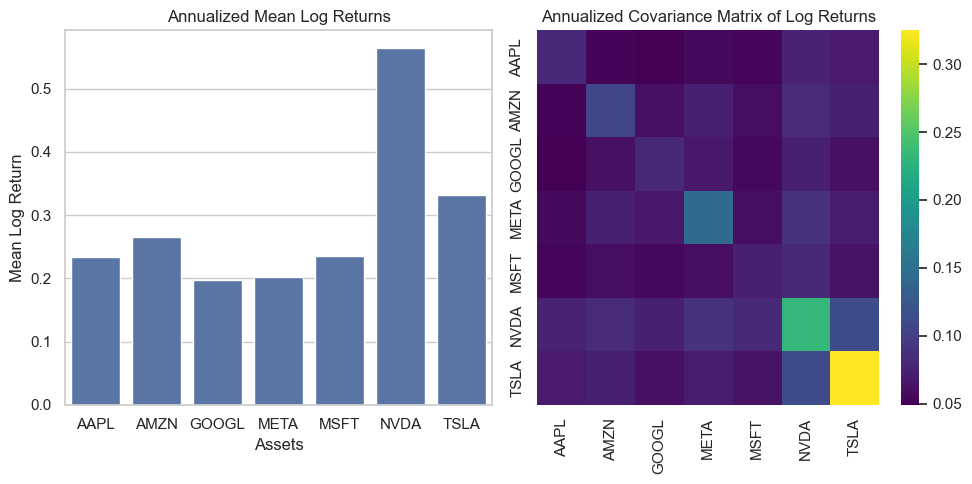

In [5]:
T, N = log_returns.shape
print(f"{N=}, {T=}")

# Compute per-day mean and covariance of log returns
mu = log_returns.mean().values # shape: (N,)
Sigma = log_returns.cov().values # shape: (N, N)
asset_names = log_returns.columns.tolist() # length: N

# Annualize mean and covariance
TRADING_DAYS = 252
mu_ann = mu * TRADING_DAYS # NOTE: Annualizing log returns is easy
Sigma_ann = Sigma * TRADING_DAYS

# Plot the mean and covariance matrix
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=asset_names, y=mu_ann)
plt.title('Annualized Mean Log Returns')
plt.ylabel('Mean Log Return')
plt.xlabel('Assets')
plt.subplot(1, 2, 2)
sns.heatmap(Sigma_ann, xticklabels=asset_names, yticklabels=asset_names, cmap='viridis')
plt.title('Annualized Covariance Matrix of Log Returns')
plt.tight_layout()
plt.show()

In [6]:
def min_variance_portfolio(mu, Sigma, target_return, allow_short=False):
    N = len(mu)
    w0 = np.ones(N) / N

    def obj(w):
        return w @ Sigma @ w # NOTE: Portfolio variance (vol**2) = w^T @ Sigma @ w
    
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights must sum to 1
        {'type': 'eq', 'fun': lambda w: w @ mu - target_return}  # NOTE: Portfolio return = w^T @ mu
    ]

    if allow_short:
        bounds = [(None, None) for _ in range(N)] # allows weights less than 0 and greater than 1
    else:
        bounds = [(0, 1) for _ in range(N)]
    
    res = minimize(obj, w0, method='SLSQP', bounds=bounds, constraints=constraints) # Minimize vol for a given target return
    if not res.success:
        raise ValueError("Optimization failed:", res.message)
    
    w_opt = res.x
    ret = w_opt @ mu
    vol = np.sqrt(w_opt @ Sigma @ w_opt)
    return w_opt, ret, vol

# Example usage
target_return = 0.2  # 20% annualized return
weights, ret, vol = min_variance_portfolio(mu_ann, Sigma_ann, target_return, allow_short=False)
print("Optimal Weights for Minimum Variance Portfolio:")
for asset, weight in zip(asset_names, weights):
    print(f"{asset}: {weight:.2%}")
print(f"Expected Annualized Return: {ret:.4f}, Volatility: {vol:.4f}")

Optimal Weights for Minimum Variance Portfolio:
AAPL: 6.05%
AMZN: 0.00%
GOOGL: 83.79%
META: 10.17%
MSFT: 0.00%
NVDA: 0.00%
TSLA: 0.00%
Expected Annualized Return: 0.2000, Volatility: 0.2749


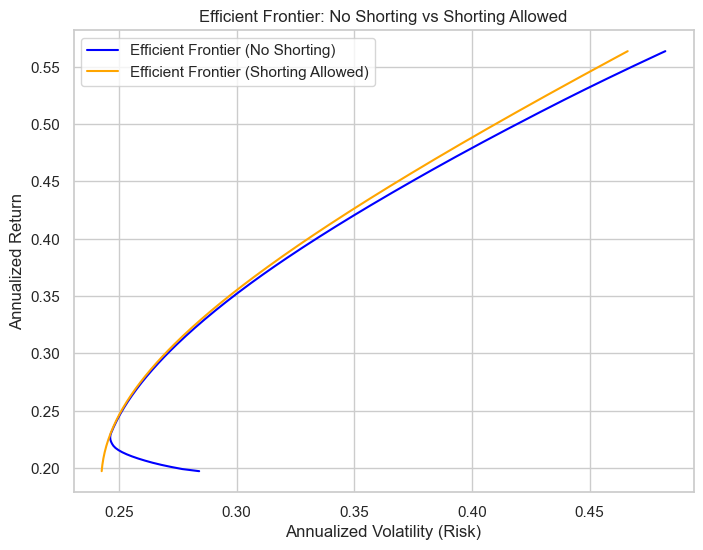

In [7]:
min_ret = mu_ann.min()
max_ret = mu_ann.max()
target_returns = np.linspace(min_ret, max_ret, 200)

# Compute efficient frontier for no shorting
frontier_vols_no_short = []
frontier_rets_no_short = []
for tr in target_returns:
    try:
        _, r, v = min_variance_portfolio(mu_ann, Sigma_ann, tr, allow_short=False)
        frontier_rets_no_short.append(r)
        frontier_vols_no_short.append(v)
    except RuntimeError:
        continue
frontier_vols_no_short = np.array(frontier_vols_no_short)
frontier_rets_no_short = np.array(frontier_rets_no_short)

# Compute efficient frontier for shorting allowed
frontier_vols_short = []
frontier_rets_short = []
for tr in target_returns:
    try:
        _, r, v = min_variance_portfolio(mu_ann, Sigma_ann, tr, allow_short=True)
        frontier_rets_short.append(r)
        frontier_vols_short.append(v)
    except RuntimeError:
        continue
frontier_vols_short = np.array(frontier_vols_short)
frontier_rets_short = np.array(frontier_rets_short)

# Plot efficient frontier for both cases
plt.figure(figsize=(8, 6))
plt.plot(frontier_vols_no_short, frontier_rets_no_short, label='Efficient Frontier (No Shorting)', color='blue')
plt.plot(frontier_vols_short, frontier_rets_short, label='Efficient Frontier (Shorting Allowed)', color='orange')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier: No Shorting vs Shorting Allowed')
plt.legend()
plt.grid(True)
plt.show()